<h1 style="text-align:center">
    Pump it Up: Data Mining the Water Table
</h1>

<h2 style="text-align:center">
    Victoria Ornela Cabrera Greco  
    <br/> <br/>
    21-03-2021
</h2>

In [3]:

import pandas as pd
import seaborn as sns  
import matplotlib.pyplot  as plt
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

## Carga Datos

In [4]:
data_test = pd.read_csv('test_set.csv')

In [5]:
data_test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [229]:
data_test.shape

(14850, 25)

In [5]:
data_train = pd.read_csv('training_set.csv')

In [9]:
data_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [10]:
data_train.shape

(59400, 40)

In [6]:
y = pd.read_csv('training_y.csv')

In [7]:
y['status_group'].unique()  #Podemos visualizar que la variable puede tomar 3 estados diferentes

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

In [8]:
#Vamos a reemplazar los valores anteriores por números, así no tenemos una variable categórica

y['status_group'] = y['status_group'].map( {'functional': 1, 'non functional': 0, 'functional needs repair':2} ).astype(int)

In [7]:
y.head()

,id,status_group
0,69572,1
1,8776,1
2,34310,1
3,67743,0
4,19728,1


In [8]:
y.isnull().sum()

id              0
status_group    0
dtype: int64

In [9]:
#Corroboremos los valores únicos que tiene nuestro dataset

len(y.id.unique())  #Podemos visualizar que coincide perfectamente con nuestro conjunto de training, lo cual es correcto

59400

In [9]:
data = data_train.merge(y, on = 'id')
data.set_index(['id'], inplace=True)

In [7]:
data.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,1
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1


In [232]:
data.shape

(59400, 26)

In [10]:
data_test.set_index(['id'], inplace=True)   #Utilizamos la columna id como índice

In [155]:
data_test.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


## EDA

In [161]:
data.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,status_group
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475,0.688434
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547,0.599877
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000,1.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000,1.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,2.000000


In [45]:
data.dtypes

amount_tsh               float64
funder                     int32
gps_height                 int64
installer                  int32
longitude                float64
latitude                 float64
wpt_name                   int32
num_private                int64
region                     int64
region_code                int64
district_code              int64
population                 int64
public_meeting             int32
scheme_management          int64
permit                     int32
construction_year          int64
extraction_type_class      int64
management_group           int64
payment_type               int64
quality_group              int64
quantity_group             int64
source_type                int64
waterpoint_type_group      int64
status_group               int32
year                       int64
month                      int64
dtype: object

In [212]:
data.isnull().sum()

amount_tsh               0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
region                   0
region_code              0
district_code            0
population               0
public_meeting           0
scheme_management        0
permit                   0
construction_year        0
extraction_type_class    0
management_group         0
payment_type             0
quality_group            0
quantity_group           0
source_type              0
waterpoint_type_group    0
status_group             0
year                     0
month                    0
dtype: int64

In [211]:
data_test.isnull().sum()

amount_tsh               0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
region                   0
region_code              0
district_code            0
population               0
public_meeting           0
scheme_management        0
permit                   0
construction_year        0
extraction_type_class    0
management_group         0
payment_type             0
quality_group            0
quantity_group           0
source_type              0
waterpoint_type_group    0
year                     0
month                    0
dtype: int64

In [104]:
##Primero vamos a eliminar las variables que se encuentran repetidas en dos variables diferentes, quedandonos con las que mayor agrupacion poseen.

data.drop(['waterpoint_type','subvillage','extraction_type_group','ward','scheme_name','basin','lga','extraction_type','management','payment','water_quality','quantity','source','source_class'], axis=1, inplace=True)

#Haremos lo mismo para el conjunto de Test

data_test.drop(['waterpoint_type','subvillage','extraction_type_group','ward','scheme_name','basin','lga','extraction_type','management','payment','water_quality','quantity','source','source_class'], axis=1, inplace=True)


KeyError: "['waterpoint_type' 'subvillage' 'extraction_type_group' 'ward'\n 'scheme_name' 'basin' 'lga' 'extraction_type' 'management' 'payment'\n 'water_quality' 'quantity' 'source' 'source_class'] not found in axis"

In [105]:
#Optamos por eliminar recorded_by ya que tiene un único valor

data.drop('recorded_by', axis=1, inplace=True)
data_test.drop('recorded_by', axis=1, inplace=True)

KeyError: "['recorded_by'] not found in axis"

In [13]:
lista_categoricas = ['funder','installer','wpt_name','region','public_meeting',
                     'scheme_management','permit',
                     'extraction_type_class','management_group','payment_type',
                     'quality_group','quantity_group','source_type','waterpoint_type_group']
lista_numericas = ['amount_tsh','gps_height','longitude','latitude','num_private','region_code','district_code','population',
                  'construction_year']

In [106]:
##Vamos a convertir el campo de fecha y luego crear dos columnas donde una será el año y otra el mes, quitando el día


data['date'] = pd.to_datetime(data['date_recorded'])
data['year'], data['month'] = data['date'].dt.year, data['date'].dt.month

data.drop(['date_recorded','date'], axis=1, inplace=True)

data_test['date'] = pd.to_datetime(data_test['date_recorded'])
data_test['year'], data_test['month'] = data_test['date'].dt.year, data_test['date'].dt.month

data_test.drop(['date_recorded','date'], axis=1, inplace=True)

In [13]:
data.shape
data.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,region,region_code,...,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source_type,waterpoint_type_group,status_group,year,month
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,0,Iringa,11,...,gravity,user-group,annually,good,enough,spring,communal standpipe,1,2011,3
8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Mara,20,...,gravity,user-group,never pay,good,insufficient,rainwater harvesting,communal standpipe,1,2013,3
34310,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Manyara,21,...,gravity,user-group,per bucket,good,enough,dam,communal standpipe,1,2013,2
67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Mtwara,90,...,submersible,user-group,never pay,good,dry,borehole,communal standpipe,0,2013,1
19728,0.0,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Kagera,18,...,gravity,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,1,2011,7


In [14]:
#Contamos los valores de cada categoria
data['permit'].value_counts()

True     38852
False    17492
Name: permit, dtype: int64

### Tratamiento valores NA

In [107]:
## Tratamiento de valores NA - Permit
#En este caso como tenemos que el 5% de los datos son NA, vamos a optar por imputarlos segun la moda

data['permit']=data['permit'].fillna(data['permit'].mode()[0])

data_test['permit']=data_test['permit'].fillna(data_test['permit'].mode()[0])

In [108]:
data['public_meeting'].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [109]:
#Vamos a optar a realizar el mismo procedimiento que con la variable permit
data['public_meeting']=data['public_meeting'].fillna(data['public_meeting'].mode()[0])

data_test['public_meeting']=data_test['public_meeting'].fillna(data_test['public_meeting'].mode()[0])

In [110]:
## Cambiamos las variables binarias a si/no

data['permit'] = data['permit'].astype(int)
data['public_meeting'] = data['public_meeting'].astype(int)

data_test['permit'] = data_test['permit'].astype(int)
data_test['public_meeting'] = data_test['public_meeting'].astype(int)

In [111]:
data['scheme_management']=data['scheme_management'].fillna(data['scheme_management'].mode()[0])
data_test['scheme_management']=data_test['scheme_management'].fillna(data_test['scheme_management'].mode()[0])

### Agrupando variables categóricas en numéricas

In [33]:
for i in lista_categoricas:
    print(i)
    print(data[i].value_counts())

funder
4    45000
1     9084
2     3114
3     2202
Name: funder, dtype: int64
installer
3    40173
1    17402
2     1825
Name: installer, dtype: int64
wpt_name
3    54089
1     3563
2     1748
Name: wpt_name, dtype: int64
region
1     5294
2     4982
3     4639
4     4379
5     4006
7     3350
6     3316
8     3102
9     2816
11    2640
10    2635
12    2547
13    2201
14    2093
16    1969
15    1959
17    1808
18    1730
19    1583
20    1546
21     805
Name: region, dtype: int64
public_meeting
1    54345
0     5055
Name: public_meeting, dtype: int64
scheme_management
1     40670
2      5206
3      3153
4      2883
5      2748
6      1680
8      1063
7      1061
9       766
10       97
11       72
12        1
Name: scheme_management, dtype: int64
permit
1    41908
0    17492
Name: permit, dtype: int64
extraction_type_class
1    26780
2    16456
3     6430
4     6179
5     2987
6      451
7      117
Name: extraction_type_class, dtype: int64
management_group
1    52490
2     3638
3    

In [210]:
for i in lista_categoricas:
    print(i)
    print(data_test[i].value_counts())

funder
4    11262
1     2215
2      793
3      580
Name: funder, dtype: int64
installer
3    10044
1     4349
2      457
Name: installer, dtype: int64
wpt_name
3    13538
1      877
2      435
Name: wpt_name, dtype: int64
region
2     1311
1     1305
3     1119
4     1115
5     1032
6      858
8      795
7      761
9      717
10     696
11     666
12     639
13     578
15     507
16     482
14     443
17     434
18     414
19     389
20     374
21     215
Name: region, dtype: int64
public_meeting
1    13559
0     1291
Name: public_meeting, dtype: int64
scheme_management
1     10093
2      1290
3       822
5       714
4       668
6       444
7       280
8       263
9       230
10       26
11       20
Name: scheme_management, dtype: int64
permit
1    10491
0     4359
Name: permit, dtype: int64
extraction_type_class
1    6483
2    4156
3    1672
4    1593
5     790
6     121
7      35
Name: extraction_type_class, dtype: int64
management_group
1    13048
2      953
3      461
4      266
5 

In [112]:
#funder

data.loc[data['funder'] == 'Government Of Tanzania', 'funder'] = 1
data.loc[data['funder'] == 'Danida', 'funder'] = 2    
data.loc[data['funder'] == 'Hesawa', 'funder'] = 3


data['funder'] = np.where((data['funder'] != 1) & (data['funder'] != 2) & (data['funder'] != 3), 4, data['funder'])

data_test.loc[data_test['funder'] == 'Government Of Tanzania', 'funder'] = 1
data_test.loc[data_test['funder'] == 'Danida', 'funder'] = 2    
data_test.loc[data_test['funder'] == 'Hesawa', 'funder'] = 3


data_test['funder'] = np.where((data_test['funder'] != 1) & (data_test['funder'] != 2) & (data_test['funder'] != 3), 4, data_test['funder'])

In [113]:
data['funder'] = data['funder'].astype(int).sort_index()
data_test['funder'] = data_test['funder'].astype(int).sort_index()

In [114]:
#installer

data['installer'] = np.where(data['installer'] == 'DWE', 1, data['installer'])
data['installer'] = np.where(data['installer'] == 'Government', 2, data['installer'])
data['installer'] = np.where((data['installer'] != 1) & (data['installer'] != 2), 3, data['installer'])

data_test['installer'] = np.where(data_test['installer'] == 'DWE', 1, data_test['installer'])
data_test['installer'] = np.where(data_test['installer'] == 'Government', 2, data_test['installer'])
data_test['installer'] = np.where((data_test['installer'] != 1) & (data_test['installer'] != 2), 3, data_test['installer'])

In [115]:
data['installer'] = data['installer'].astype(int)
data_test['installer'] = data_test['installer'].astype(int)

In [116]:
#wpt name

data['wpt_name'] = np.where(data['wpt_name'] == 'none', 1, data['wpt_name'])
data['wpt_name'] = np.where(data['wpt_name'] == 'Shuleni', 2, data['wpt_name'])
data['wpt_name'] = np.where((data['wpt_name'] != 1) & (data['wpt_name'] != 2), 3, data['wpt_name'])

data_test['wpt_name'] = np.where(data_test['wpt_name'] == 'none', 1, data_test['wpt_name'])
data_test['wpt_name'] = np.where(data_test['wpt_name'] == 'Shuleni', 2, data_test['wpt_name'])
data_test['wpt_name'] = np.where((data_test['wpt_name'] != 1) & (data_test['wpt_name'] != 2), 3, data_test['wpt_name'])


In [117]:
data['wpt_name'] = data['wpt_name'].astype(int)
data_test['wpt_name'] = data_test['wpt_name'].astype(int)

In [118]:
#region

data.region.replace(('Iringa','Shinyanga','Mbeya','Kilimanjaro','Morogoro','Kagera','Arusha','Mwanza','Kigoma'
                     ,'Pwani','Ruvuma','Tanga','Dodoma','Singida','Tabora','Mara','Rukwa','Mtwara','Manyara','Lindi','Dar es Salaam'),
                      (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21),inplace=True)

data_test.region.replace(('Iringa','Shinyanga','Mbeya','Kilimanjaro','Morogoro','Kagera','Arusha','Mwanza','Kigoma'
                     ,'Pwani','Ruvuma','Tanga','Dodoma','Singida','Tabora','Mara','Rukwa','Mtwara','Manyara','Lindi','Dar es Salaam'),
                      (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21),inplace=True)

In [119]:
#scheme_management

data.scheme_management.replace(('VWC','WUG','Water authority','WUA','Water Board','Parastatal','Company','Private operator','Other'
                     ,'SWC','Trust','None'),
                      (1,2,3,4,5,6,7,8,9,10,11,12),inplace=True)

data_test.scheme_management.replace(('VWC','WUG','Water authority','WUA','Water Board','Parastatal','Company','Private operator','Other'
                     ,'SWC','Trust','None'),
                      (1,2,3,4,5,6,7,8,9,10,11,12),inplace=True)

In [120]:
#extraction type class

data.extraction_type_class.replace(('gravity','handpump','other','submersible','motorpump','rope pump','wind-powered'),
                      (1,2,3,4,5,6,7),inplace=True)

data_test.extraction_type_class.replace(('gravity','handpump','other','submersible','motorpump','rope pump','wind-powered'),
                      (1,2,3,4,5,6,7),inplace=True)

In [121]:
#management group

data.management_group.replace(('user-group','commercial','parastatal','other','unknown'),
                      (1,2,3,4,5),inplace=True)

data_test.management_group.replace(('user-group','commercial','parastatal','other','unknown'),
                      (1,2,3,4,5),inplace=True)

In [122]:
#payment type

data.payment_type.replace(('never pay','per bucket','monthly','unknown','on failure','annually','other'),
                      (1,2,3,4,5,6,7),inplace=True)

data_test.payment_type.replace(('never pay','per bucket','monthly','unknown','on failure','annually','other'),
                      (1,2,3,4,5,6,7),inplace=True)

In [123]:
#quality group

data.quality_group.replace(('good','salty','unknown','milky','colored','fluoride'),
                      (1,2,3,4,5,6),inplace=True)

data_test.quality_group.replace(('good','salty','unknown','milky','colored','fluoride'),
                      (1,2,3,4,5,6),inplace=True)

In [124]:
#quantity group

data.quantity_group.replace(('enough','insufficient','dry','seasonal','unknown'),
                      (1,2,3,4,5),inplace=True)

data_test.quantity_group.replace(('enough','insufficient','dry','seasonal','unknown'),
                      (1,2,3,4,5),inplace=True)

In [125]:
#source type

data.source_type.replace(('spring','shallow well','borehole','river/lake','rainwater harvesting','dam','other'),
                      (1,2,3,4,5,6,7),inplace=True)

data_test.source_type.replace(('spring','shallow well','borehole','river/lake','rainwater harvesting','dam','other'),
                      (1,2,3,4,5,6,7),inplace=True)

In [126]:
#waterpoint type group

data.waterpoint_type_group.replace(('communal standpipe','hand pump','other','improved spring'
                          ,'cattle trough','dam'),
                      (1,2,3,4,5,6),inplace=True)

data_test.waterpoint_type_group.replace(('communal standpipe','hand pump','other','improved spring'
                          ,'cattle trough','dam'),
                      (1,2,3,4,5,6),inplace=True)

### Variables numéricas

In [230]:
for i in lista_numericas:
    print(i)
    print(data[i].value_counts())

amount_tsh
0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64
gps_height
 0       20438
-15         60
-16         55
-13         55
-20         52
         ...  
 2285        1
 2424        1
 2552        1
 2413        1
 2385        1
Name: gps_height, Length: 2428, dtype: int64
longitude
0.000000     1812
37.540901       2
33.010510       2
39.093484       2
32.972719       2
             ... 
37.579803       1
33.196490       1
34.017119       1
33.788326       1
30.163579       1
Name: longitude, Length: 57516, dtype: int64
latitude
-2.000000e-08    1812
-6.985842e+00       2
-3.797579e+00       2
-6.981884e+00       2
-7.104625e+00       2
                 ... 
-5.726001e+00       1
-9.646831e+00       1
-8.124530e+00       1
-2.535985e+00       1
-2.598965e+00       1
Name: latitude, Length:

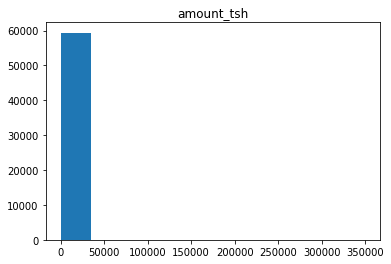

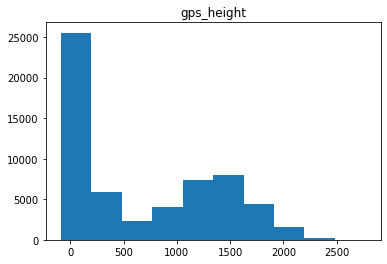

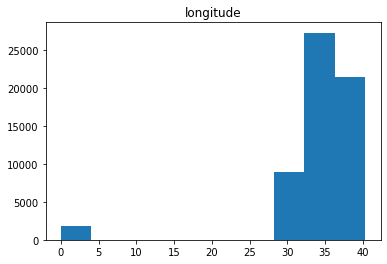

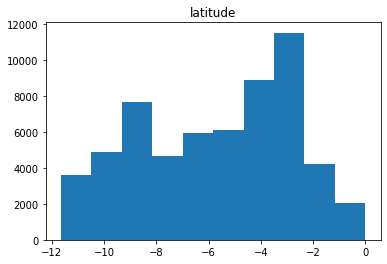

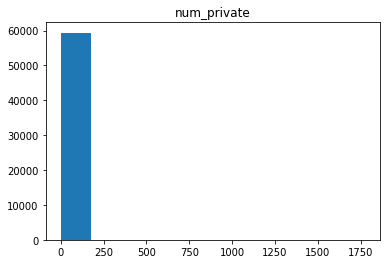

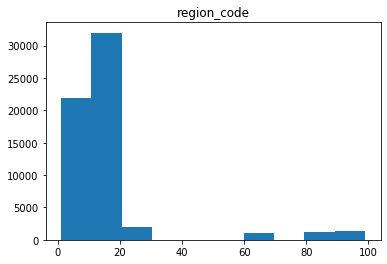

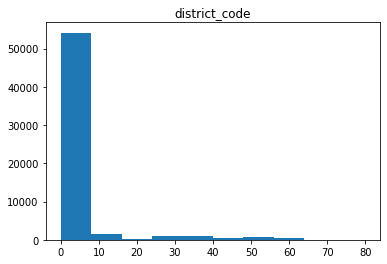

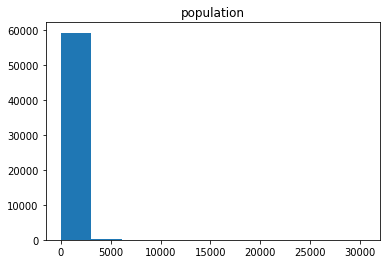

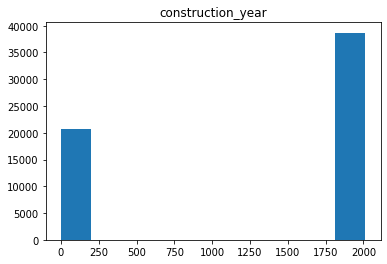

In [227]:
for l in lista_numericas:
    plt.hist(data[l])
    plt.title(l)
    plt.show()

### Seleccion de variables

In [37]:
from sklearn.feature_selection import VarianceThreshold

In [38]:
target = 'status_group'
features = list(data.columns)
features.remove('status_group')

x = data[features]
y = data[target]

In [39]:
var_th = VarianceThreshold(threshold = 0.40)
x_var = var_th.fit_transform(x)

In [40]:
x.shape[1]

25

In [41]:
x_var.shape[1]

22

In [42]:
np.asarray(list(x))[var_th.get_support()]

array(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'num_private', 'region', 'region_code',
       'district_code', 'population', 'scheme_management',
       'construction_year', 'extraction_type_class', 'management_group',
       'payment_type', 'quality_group', 'quantity_group', 'source_type',
       'waterpoint_type_group', 'year', 'month'], dtype='<U21')

### Multicolinealidad

In [43]:
from sklearn.linear_model import LinearRegression

In [44]:

data_vif = data.copy(deep = True)
features = list(data_vif.columns)
features.remove('status_group')

data_vif = data_vif[features]

for i in range(len(features)):
    var = features[i]  #cada una de las posiciones de features
    fet = features[:]
    fet.remove(var)
    
    x = data_vif[fet]
    y = data[var]
    
    model = LinearRegression()
    model.fit(x, y)
    
    vif = 1 / (1 - model.score(x, y))
    
    print ('El valor del VIF para la variable', var, 'es:', vif)

El valor del VIF para la variable amount_tsh es: 1.0274470303459777
El valor del VIF para la variable funder es: 1.1075777334438799
El valor del VIF para la variable gps_height es: 2.66009915051693
El valor del VIF para la variable installer es: 1.1556231004008788
El valor del VIF para la variable longitude es: 1.5637989252013695
El valor del VIF para la variable latitude es: 1.7711103599890392
El valor del VIF para la variable wpt_name es: 1.4624465309681995
El valor del VIF para la variable num_private es: 1.0042903783940011
El valor del VIF para la variable region es: 1.850848453838567
El valor del VIF para la variable region_code es: 2.5579019100087446
El valor del VIF para la variable district_code es: 2.110737535067312
El valor del VIF para la variable population es: 1.109730365606478
El valor del VIF para la variable public_meeting es: 1.0905319732617116
El valor del VIF para la variable scheme_management es: 1.5317229422308551
El valor del VIF para la variable permit es: 1.1188

In [124]:
## Correlacion

In [45]:
corr = abs(data.corr())
corr[['status_group']].sort_values(by = 'status_group',ascending = False).style.background_gradient()

,status_group
status_group,1.000000
quantity_group,0.222332
extraction_type_class,0.195305
waterpoint_type_group,0.167433
region,0.148345
quality_group,0.100449
payment_type,0.096379
funder,0.093340
region_code,0.084491
longitude,0.081915


## Partición train - test 

In [46]:
y_t = data['status_group']

In [47]:
data.drop('status_group', axis=1, inplace=True)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(data, y_t, test_size = 0.2, random_state = 42)

In [49]:
X_train.shape

(47520, 25)

In [50]:
X_test.shape

(11880, 25)

In [51]:
y_train.shape

(47520,)

In [69]:
y

id
69572    3
8776     3
34310    2
67743    1
19728    7
        ..
60739    5
27263    5
37057    4
31282    3
26348    3
Name: month, Length: 59400, dtype: int64

## Evaluación modelos 

### Random Forest

In [132]:
model1 = RandomForestClassifier(n_estimators=100, random_state=42)  #random forest
model1


RandomForestClassifier(random_state=42)

### Validación cruzada

In [53]:
##No puede hacer la validacion cruzada por un tema de memoria

results = cross_val_score(estimator=model1, X=X_train, y=y_train, cv=5) 
results

array([0.79545455, 0.79903199, 0.80113636, 0.80397727, 0.79882155])

## Ensemble methods

### Boosting

In [54]:
%time
model = XGBClassifier()
model.fit(X_train,y_train)

y_pred=model.predict(X_test)


Wall time: 0 ns
[11:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\viqic\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [55]:
from sklearn.metrics import accuracy_score

In [56]:
accuracy_score(y_test,y_pred)

0.7927609427609428

### PCA

In [80]:
pca = PCA(n_components = None)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

In [73]:
explained_variance

array([8.64905644e-01, 9.97400368e-02, 1.96842000e-02, 1.56161264e-02,
       2.79979276e-05, 1.47895556e-05, 4.03372208e-06, 2.92893706e-06,
       1.92760569e-06, 6.91007397e-07, 4.38524670e-07, 3.04140625e-07,
       2.13121811e-07, 1.36728316e-07, 1.12716821e-07, 9.72041672e-08,
       8.19231695e-08, 5.93097649e-08, 4.53175187e-08, 3.94610597e-08,
       3.46408219e-08, 2.51359046e-08, 1.71404662e-08, 1.28645767e-08,
       5.98516986e-09])

### Automatización modelo

### Grid Search

In [130]:
from sklearn.model_selection import GridSearchCV

In [131]:
grid_param = {
    'n_estimators': [300, 500, 800, 1000],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

In [135]:
model_grid = GridSearchCV(estimator=model1,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [60]:
model_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'n_estimators': [300, 500, 800, 1000]},
             scoring='accuracy')

In [61]:
print(model_grid.best_params_)

{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 800}


In [62]:
print(model_grid.best_score_)

0.8014309764309763


## Feature Engineering 

Basándonos en el previo análisis que hemos realizado sobre las variables de naturaleza numéricas, procederemos a realizar unos ajustes y visualizar si nuestro accuracy mejora.

* Amount_tsh: notamos que casi el 70% de los valores se encuentran en 0. Por lo tanto, podemos optar por tramificar la variable. Tomando 0 o 1, es decir si hay agua disponible o no en ese punto.

* gps_height:en este caso tenemos un 30% de las variables que tienen un 0 

* longitude, latitude: en este caso tendría que ser un error, ya que la interseccion de ambas variables es en el océano. Para longitude podemos visualizar que tenemos la misma cantidad que en longitud, ya que -2.e-8 ~ 0 .

* year: hay muchos registros que seguramente al desconocer el año de construccion, le asignaron un 0. Pero no sería un valor válido. 

* population: crearía rangos 

In [22]:
for i in lista_numericas:
    print(i)
    print(data[i].value_counts())

amount_tsh
0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64
gps_height
 0       20438
-15         60
-16         55
-13         55
-20         52
         ...  
 2285        1
 2424        1
 2552        1
 2413        1
 2385        1
Name: gps_height, Length: 2428, dtype: int64
longitude
0.000000     1812
37.540901       2
33.010510       2
39.093484       2
32.972719       2
             ... 
37.579803       1
33.196490       1
34.017119       1
33.788326       1
30.163579       1
Name: longitude, Length: 57516, dtype: int64
latitude
-2.000000e-08    1812
-6.985842e+00       2
-3.797579e+00       2
-6.981884e+00       2
-7.104625e+00       2
                 ... 
-5.726001e+00       1
-9.646831e+00       1
-8.124530e+00       1
-2.535985e+00       1
-2.598965e+00       1
Name: latitude, Length:

In [96]:
#Amount_tsh -  Total static head (amount water available to waterpoint)

data['amount_water'] = data['amount_tsh'].apply(lambda x: 0 if x==0 else 1)
#data_test['amount_water'] = data_test['amount_tsh'].apply(lambda x: 0 if x==0 else 1)

In [71]:
def tramos(varib,varib_destino,tamanio,maximo,df):
    df[varib_destino]=np.where(df[varib]==0,0,(df[varib]//tamanio)*tamanio)
    df[varib_destino]=np.where(df[varib_destino]>=maximo,maximo,df[varib_destino])

In [97]:
#population
tramos('population','population_tramo',1000,30500,data)
#tramos('population','population_tramo',1000,30500,data_test)

In [102]:
#para el año de construccion, probaremos con intervalos también

data['year_tramo']=np.where(data['construction_year']==0,0,(data['construction_year']//10)*10)
#data_test['year_tramo']=np.where(data_test['construction_year']==0,0,(data_test['construction_year']//10)*10)


In [101]:
data['year_tramo']=np.where(data['year_tramo']>=2500,2500,data['year_tramo'])
#data_test['year_tramo']=np.where(data_test['year_tramo']>=2500,2500,data_test['year_tramo'])


In [127]:
corr = abs(data.corr())
corr[['status_group']].sort_values(by = 'status_group',ascending = False).style.background_gradient()

,status_group
status_group,1.000000
quantity_group,0.222332
extraction_type_class,0.195305
amount_water,0.175545
waterpoint_type_group,0.167433
region,0.148345
quality_group,0.100449
payment_type,0.096379
funder,0.093340
region_code,0.084491


In [128]:
#Para diferenciar la partición del "nuevo modelo" con el anterior, crearemos una nueva variable

data1 = data

In [134]:
y_t1 = data1['status_group']
data1.drop('status_group', axis=1, inplace=True)
X_train1, X_test1, y_train1, y_test1 = train_test_split(data1, y_t1, test_size = 0.2, random_state = 42)

In [136]:
model_grid.fit(X_train1, y_train1)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'n_estimators': [300, 500, 800, 1000]},
             scoring='accuracy')

In [137]:
print(model_grid.best_params_)

{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 500}


In [138]:
print(model_grid.best_score_)

0.800736531986532


## Entrenamiento modelo

In [63]:
modelo = RandomForestClassifier(bootstrap=True, criterion='entropy',n_estimators=800)
modelo.fit(data,y_t)

RandomForestClassifier(criterion='entropy', n_estimators=800)

## Predicciones

In [64]:
pred = modelo.predict(data_test)

In [65]:
pred

array([0, 1, 1, ..., 1, 1, 0])

In [67]:
prediction = pd.Series(pred,name='status_group')
prediction

0        0
1        1
2        1
3        0
4        1
        ..
14845    0
14846    1
14847    1
14848    1
14849    0
Name: status_group, Length: 14850, dtype: int32

In [68]:
test_id = pd.Series(data_test.index,name='id')
test_id

0        50785
1        51630
2        17168
3        45559
4        49871
         ...  
14845    39307
14846    18990
14847    28749
14848    33492
14849    68707
Name: id, Length: 14850, dtype: int64

In [69]:
pred_df = pd.concat([test_id,prediction], axis=1)

In [77]:
pred_df

,id,status_group
0,50785,1
1,51630,1
2,17168,1
3,45559,0
4,49871,1
...,...,...
14845,39307,0
14846,18990,1
14847,28749,1
14848,33492,1


In [80]:
pred_df['status_group'] = pred_df['status_group'].map( {1:'functional',0: 'non functional', 2:'functional needs repair'} )

In [81]:
pred_df

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


In [82]:
pred_df.to_csv('predictions',index=False)

## Guardar modelo

In [84]:
import pickle

pkl_file = 'Pump_it_Forest'
with open(pkl_file,'wb') as file:
    pickle.dump(modelo,file)